# 16. 불안한 시선 이펙트 추가하기

## 1. 들어가며

지난 시간에 이어서 눈동자를 검출 할 수 있는 방법에 대해 다루겠다. 이런 태스크를 위해 꼭 필요한 데이터셋이 충분히 갖추어져 있지 않은 상황을 우리는 헤쳐나가야 한다.

이번 시간의 목표이다.

1. 공개 데이터 사용해서 라벨 직접 모아보기
2. 색상 값을 이용한 검출 방법
3. 라벨링 툴 만들기 - point selection
4. 째려보는 효과 구현하기

### 준비물

---

아직 프로젝트 폴더를 만들지 않았다면, 터미널을 열고 개인 실습 환경에 따라 경로를 수정, 프로젝트를 위한 디렉토리를 생성하자.

```bash
$ mkdir -p ~/aiffel/coarse_to_fine/data
```

[coarse_to_fine_pjt.zip](https://aiffelstaticprd.blob.core.windows.net/media/documents/coarse_to_fine_pjt.zip)

위 제공한 압축파일을 다운로드받아 아래와 같이 해당 디렉토리에서 작업하자.

```
$ cd ~/aiffel/coarse_to_fine
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/coarse_to_fine_pjt.zip
$ unzip coarse_to_fine_pjt.zip
```

> _이번 시간에는 주피터 커널 대신 코드 에디터와 터미널을 사용하자. 다음에 나올 코드를 붙여넣어 적절한 파일로 저장 후 사용하면 된다._

## 2. 위치 측정을 위한 라벨링 툴 만들기 (1) OpenCV 사용

> _이번 시간에는 주피터 커널 대신 코드 에디터와 터미널을 사용하자. 아래 있는 코드를 붙여넣어 적절한 파일로 저장 후 사용하면 된다._

이전 노드에[서는 True/False를 라벨링(labeling)할 수 있는 도구를 만들어 보았다. 품질이 좋지 못한 데이터에 위치를 직접 입력하려면 어떻게 해야 할까? 이번에는 눈동자 위치를 선택할 수 있는 도구를 만들어 보겠다.

예를 들어, 아래와 같은 눈 이미지가 있다.

<img src="./image/eye1.png" />

기존 예측 결과는 이상한 곳을 측정했다. 이런 경우 눈동자 위치를 새로 지정해서 fine 라벨로 만들어야 한다.

<img src="./image/eye2.png" />

정확한 곳을 지정하기 위해서 마우스를 사용해야 할 것 같은데.. 마우스 이벤트를 사용하는 방법이 있을까?

<img src="./image/eye3.png" />

다행히 **`OpenCV`**에서 마우스 이벤트를 callback 함수 형태로 지원한다.

callback 함수가 무엇인지는 아래 링크를 참고.

- [콜백 함수(Callback)의 정확한 의미는 무엇일까?](https://satisfactoryplace.tistory.com/18)

__callback 함수는 무엇인가?__

* 어떤 이벤트에 의해 호출되어지는 함수, 다른 함수의 인자로 이용되는 함수

**`OpenCV`**에서 지원하는 마우스 이벤트 형태는 아래 참고자료를 통해 확인해보자.

- [Mouse로 그리기 - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/04.drawWithMouse/drawWithMouse.html)

__OpenCV에서 마우스 이벤트를 확인하고 callback을 호출하는 함수는 무엇인가?__

* cv2.setMouseCallback

__OpenCV에서 마우스 왼쪽 버튼이 눌러졌을 때 `on` 되는 `flag` 는 무엇인가?__

* cv2.EVENT_LBUTTONDOWN

## 3. 위치 측정을 위한 라벨링 툴 만들기 (2) 툴 만들기

이제 OpenCV의 마우스 이벤트를 이용해서 라벨링 툴(labeling tool)을 만들어보겠다.

아래 코드를 복사해 **`keypoint_using_mouse.py`**로 저장하자.<br>
(참고) **`들어가며`** 스텝에서 다운받은 코드 중에 이미 포함되어 있으니 참고하자.

아래 코드는 필요한 패키지를 불러온다. 주로 **`cv2`** 를 이용한다. 이번에는 기존 라벨을 읽지 않고 새로 위치를 정하기 때문에 **`img_path`** 만 불러오면 된다. **`flg_button`** 은 마우스 이벤트가 발생할 때 사용할 불리언(boolean) 타입 전역변수이다.

```python
import os
from os.path import join
from glob import glob
import cv2
import argparse
import numpy as np
import json
from pprint import pprint

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('img_path', type=str, nargs='?', default=None)

config = args.parse_args()

flg_button = False

```

사용할 함수를 만들겠다.

해당 함수에서는 먼저 **`img_path`** 가 유효한지 체크한다. **`img_path`** 로 디렉토리가 입력될 경우 해당 디렉토리 내의 첫 번째 이미지를 **`img_path`** 에 입력하고 경로를 반환한다.

이미지 간 이동할 **`move()`** 함수도 선언한다.

```python
def check_dir():
    if config.img_path is None \
        or len(config.img_path) == 0 \
        or config.img_path == '' \
        or os.path.isdir(config.img_path):
        root = os.path.realpath('./')
        if os.path.isdir(config.img_path):
            root = os.path.realpath(config.img_path)
        img_list = sorted(glob(join(root, '*.png')))
        img_list.extend(sorted(glob(join(root, '*.jpg'))))
        config.img_path = img_list[0]

    img_dir = os.path.dirname(os.path.realpath(config.img_path))

    return img_dir

def move(pos, idx, img_list):
    if pos == 1:
        idx += 1
        if idx == len(img_list):
            idx = 0
    elif pos == -1:
        idx -= 1
        if idx == -1:
            idx = len(img_list) - 1
    return idx

```

mouse callback 함수를 정의한다. 전역변수인 **`gparam`** 에는 **`img`**와 **`point`** 정보를 저장한다. 마우스 왼쪽 버튼이 눌러졌다 떨어질 때 **`gparam`** 의 **`point`** 에 **`x, y`** 를 리스트로 저장한다.

```python
# Mouse callback functiondef select_point(event, x,y, flags, param):
    global flg_button, gparam
    img = gparam['img']

    if event == cv2.EVENT_LBUTTONDOWN:
        flg_button = True

    if event == cv2.EVENT_LBUTTONUP and flg_button == True:
        flg_button = False
        print (f'({x}, {y}), size:{img.shape}')
        gparam['point'] = [x,y]

```

**`main`** 함수인 **`blend_view()`** 를 구현하자. 마찬가지로 코드를 복사해 **`keypoint_using_mouse.py`**에 붙여넣자.

```python
def blend_view():
    global gparam
    gparam = {}
    cv2.namedWindow('show', 0)
    cv2.resizeWindow('show', 500, 500)

    img_dir = check_dir()

    fname, ext = os.path.splitext(config.img_path)
    img_list = [os.path.basename(x) for x in sorted(glob(join(img_dir,'*%s'%ext)))]

    dict_label = {}
    dict_label['img_dir'] = img_dir
    dict_label['labels'] = {}

    json_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/eye_annotation.json'
    json_file = open(json_path, 'w', encoding='utf-8')

    idx = img_list.index(os.path.basename(config.img_path))
    pfname = img_list[idx]
    orig = None
    local_point = []# 저장할 point listwhile True:
        start = cv2.getTickCount()
        fname = img_list[idx]
# 파일의 변경이 없거나 이미지가 없을 때, point 를 초기화함if pfname != fname or orig is None:
            orig = cv2.imread(join(img_dir, fname), 1)
            gparam['point'] = []
            pfname = fname
# 저장할 point(local point) 와 새로 지정한 gparam['point'] 가 변경된 경우,# local_point 를 업데이트if local_point != gparam['point']:
            orig = cv2.imread(join(img_dir, fname), 1)
            local_point = gparam['point']

        img_show = orig
        gparam['img'] = img_show
        cv2.setMouseCallback('show', select_point)# mouse eventif len(local_point) == 2:
            img_show = cv2.circle(img_show, tuple(local_point),
                                  2, (0,255,0), -1)
            dict_label['labels'][fname] = local_point# label 로 저장

        time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

        if img_show.shape[0] > 300:
            cv2.putText(img_show, '%s'%fname, (5,10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255,255,255))

        print (f'[INFO] ({idx+1}/{len(img_list)}) {fname}... time: {time:.3f}ms', end='\r')

        cv2.imshow('show', img_show)

        key = cv2.waitKey(1)
        if key == 27:
            return -1
        if key == ord('n'):
            idx = move(1, idx, img_list)
        elif key == ord('p'):
            idx = move(-1, idx, img_list)
        elif key == ord('v'):
            print ()
            pprint (dict_label)
            print ()
        elif key == ord('s'):
            json.dump(dict_label, json_file, indent=2)
            print (f'[INFO] < {json_path} > saved!')

if __name__ == '__main__':
    blend_view()

```

**`main`** 함수인 **`blend_view()`** 는 이론 노드에서 만든 라벨링 툴의 구조와 비슷하게 구현했다.

달라진 점은,

- 마우스 이벤트를 사용하기 위해 무한루프를 사용해서 **`gparam`**을 입력 받을 수 있게 한 것
- 이미지 변경이 없다면 **`gparam['point']`** 를 초기화하지 않을 것
- 이미지 변경이 없더라도 callback 함수에서 **`gparam`** 변경이 일어나는 경우는 수정할 것

이 있다.

만든 프로그램을 실행시켜서 마우스로 점을 찍어보자.

우선 위 이미지를 다운받아, **`eye.png`** 이름으로 현재 프로젝트 폴더의 하위 디렉토리인 **`data`** 에 저장한 후, 아래 코드를 터미널에서 실행한다.

```bash
$ cd ~/aiffel/coarse_to_fine
$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/1_hZAciQ9.png -O ./data/eye.png
$ python keypoint_using_mouse.py ./data/eye.png

```

눈동자 지점을 클릭한 후 **`s`**를 눌러 저장하면 **`esc`**를 눌러 프로그램을 종료할 때 <br> **`~/aiffel/coarse_to_fine/eye_annotation.json`** 에 레이블이 저장된다.

이제 레이블을 모아서 학습시킬 수 있다!

## 4. 데이터를 모아보자

이제 라벨링할 초기 데이터를 수집해야 한다. 직접 촬영한 데이터를 쓸 수도 있지만 들이는 노력에 비해 데이터가 많이 모이지 않는다. 때문에 공개된 데이터를 적극적으로 활용할 필요가 있다.

우리가 모아야 할 라벨은 눈동자 위치이기 때문에 아래 순서로 데이터셋을 찾으면 좋다.

1. 눈이 crop 되어 있고 눈동자 위치를 라벨로 가지고 있는 데이터
2. 얼굴 랜드마크(face landmark)를 가지고 있는 데이터
3. 얼굴 이미지를 가지고 있는 데이터

1번에 해당하는 데이터셋은 **BioID** 가 있다.

- [BioID Face Database | Dataset for Face Detection | facedb - BioID](https://www.bioid.com/facedb/)

__BioID는 몇 장의 이미지를 가지고 있을까? 이미지 해상도는 얼마일까?__

* 1,521장의 gray image, 384x286

__BioID는 몇 명의 사람으로 구성되어있는가?__

* 23명

BioID의 경우 우리가 해결해야 할 문제를 위한 데이터셋이지만 규모가 너무 작다는 단점이 있다. 충분한 양의 이미지를 수집하기 위해 다른 데이터셋도 조사해야 한다.

얼굴 랜드마크가 제공되는 데이터를 생각해보자. 랜드마크가 제공되는 경우는 눈 부분의 사진을 쉽게 crop해서 사용할 수 있기 때문에 라벨을 쉽게 만들 수 있다.

### 랜드마크를 제공하는 데이터셋을 찾아보자

---

랜드마크를 제공하는 데이터셋을 찾아보자. 데이터를 어떻게 찾아가는지 함께 고민하는 것에 집중하자.

우리는 **`dlib`** 패키지의 얼굴 랜드마크를 사용해오고 있다. 그렇다면 **`dlib`** 패키지를 구현하기 위해 사용된 랜드마크는 어떤 데이터셋으로 학습되었을까? 를 생각해보면 간단히 데이터를 찾을 수 있다.

구글에 "dlib face landmark dataset"을 검색해보자. 검색 첫 페이지에서 아래 링크를 찾을 수 있다.

- [http://dlib.net/face_landmark_detection.py.html](http://dlib.net/face_landmark_detection.py.html)

주석을 몇 줄 읽어보면 어떤 데이터셋을 사용해서 학습했는지 친절하게 안내되어 있다.

```
#   and was trained on the iBUG 300-W face landmark dataset (see
#   https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/):
```

**`iBUG 300-W`** 라는 데이터셋으로 학습했다고 한다. 이 데이터셋을 이용하는 방법도 유용할 것이다.

이 경우에는 운이 좋았다. 하지만 실무에서 대부분의 경우는 내가 풀고자 하는 문제의 관련 도메인 데이터셋이 없기 때문에 위에서 알아본 방법 중 3번 방법도 고려해야 한다.

3번 방법을 연습해 보기 위해, 오늘은 LFW 데이터셋을 사용해보자. 이 데이터셋은 **안면 인식(face recognition)**과 관련된 데이터셋이다 (해당 사진이 누구의 얼굴인지 판단하는 데이터셋이다). 얼굴이 포함된 이미지만 있고 얼굴의 랜드마크에 대한 정보는 없는 데이터셋이다. 이 이미지에 **`dlib`**을 적용해서 얼굴 위치와 랜드마크 위치를 찾고 눈을 잘라낸 뒤 라벨링을 할 수 있다.

데이터는 아래 링크에서 다운로드 받을 수 있다.

- [http://vis-www.cs.umass.edu/lfw/lfw.tgz](http://vis-www.cs.umass.edu/lfw/lfw.tgz)

```bash
$ cd ~ && wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
$ tar -xvzf lfw.tgz
```

위와 같이 다운로드 후 압축을 풀면 아래와 같은 이미지를 볼 수 있다.

<img src="./image/lfw.png" />
<center><b>[LFW 데이터셋 예시]</b></center>

## 5. Mean-shift를 이용한 눈동자 검출 방법 (1) 이론

<img src="./image/mean_shift.png" />

눈동자를 어떻게 검출할까? 쉽게 떠오르는 방법은 **"눈동자는 주변 부분에 비해 어두운 색을 지니고 있다."** 를 가정으로 반전된 1D 이미지에서 최댓값을 찾는 방법이다.

<img src="./image/mean_shift2.png" />
<center><b>[위 이미지의 하단 및 우측 1차원 벡터에서 최대값을 찾는 방법을 사용했습니다.]</b></center>

물론 이와 같은 가우시안 블러가 모든 상황을 해결할 수 있는 방법은 아니다. 아래 이미지와 같이 눈 근처에 머리카락이 나타나서 눈 가장자리에 검정색이 큰 비중으로 등장하는 경우는 눈동자보다 가장자리에 수렴할 확률이 높다. 특히 머리가 긴 분들에게 자주 나타날 수 있는 현상이다.

<img src="./image/mean_shift3.png" />

2차원 블러 특성 이미지(feature image)에서는 눈동자가 2차원 정규분포로 나타나는 영역이 있는 것으로 보인다. 하지만 1차원 누적 그래프를 보면 x축으로 2개의 봉우리를 가지는 것을 관찰할 수 있다. 최댓값을 찾는 알고리즘을 왼쪽부터 시작했다면 가장 왼쪽에서 만나는 255에 수렴할 것이다.

따라서 우리는 **1D 누적 그래프**와 **2D 특성 이미지**를 모두 사용한다. 2D에서는 어떻게 최고점을 찾아갈 수 있을까?

<img src="./image/mean_shift4.png" />

1. **이미지 중심점을 초기값으로 설정하겠다.**<br>눈의 중심에 눈동자가 있을 확률이 높기 때문에 초기값으로 정하기에 아주 좋다.
2. **중심점을 기준으로 작은 box를 설정한다.**<br>box의 크기는 문제에 따라 적절한 값을 설정해야 한다. 그림에서 회색박스를 생각하면 된다.
3. **box 내부의 pixel 값을 이용해서 '무게중심'을 찾는다.**<br>이 때 무게중심은 pixel intensity를 weight 로 사용할 수 있다.
4. **찾은 무게중심을 새로운 box의 중심으로 설정한다.**<br>이 단계에서 박스가 이동하게 된다. 이제 회색박스에서 초록색박스로 관심영역이 이동했다.
5. **다시 초록색 박스를 기준으로 2-4를 반복한다.**
6. **중심점이 수렴할 때 까지 2~5를 반복하면 수렴한 점의 위치로 눈동자를 찾을 수 있다.**

머신러닝에 이미 비슷한 알고리즘이 존재한다. 현재 위치와 탐색반경을 가질 때 평균의 위치를 이용해서 반복적으로 움직이는 알고리즘인 **Mean Shift** 라는 알고리즘이다.

<img src="./image/mean_shift5.png" />

mean shift는 탐색반경 내 데이터 포인트의 평균을 구하고 평균 위치로 이동을 반복해 가면서 데이터 분포의 중심으로 이동한다. 더 자세한 설명은 아래 링크를 참고.

- [영상추적#1 - Mean Shift 추적](https://darkpgmr.tistory.com/64)

__mean shift를 이용해서 global optima를 찾을 수 있는 방법.__

* 그런 방법은 존재하지 않는다. mean shift는 local optima에만 수렴하기 때문이다.

__mean shift 의 단점__

* 초기값에 따라 수렴 위치가 달라진다. 항상 일정한 성능을 보장하기 힘들다.

__mean shift는 컴퓨터 비전의 어떤 분야에 응용할 수 있을까?__

* Mean Shift는 물체추적(object tracking), 영상 세그멘테이션(segmentation), 데이터 클러스터링(clustering), 경계를 보존하는 영상 스무딩(smoothing) 등 다양하게 활용될 수 있다.

__1차원 데이터 분포에 mean shift를 적용하면 어떤 형태를 나타낼까?__

* 가우시안 분포에서 등산하듯이 위로 올라가는 형태를 나타낸다.

## 6. Mean-shift를 이용한 눈동자 검출 방법 (2) 실습

눈동자를 검출하는 mean shift 기법을 코드로 구현해보자. 오늘의 시작포인트는 바로 지난 노드에서 구현해 보았던 눈동자 찾기 실습코드이다.

해당 코드를 하나의 파일로 정리하여 **`eye_center_basic.py`**에 저장하였다. 이 코드를 이후 실습의 베이스라인으로 사용하겠다.

```python
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib
import argparse

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('show_substep', type=bool, nargs='?', default=False)

config = args.parse_args()



img = cv2.imread('./images/image.png')
print (img.shape)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

if config.show_substep:
    plt.imshow(img_rgb)
    plt.show()


def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()

    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl

    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6

    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

# 눈 이미지 crop
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape) # (26, 47, 3)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
    plt.show()


# 눈 이미지에서 중심을 찾는 함수
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]

# 눈동자 검출 wrapper 함수
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

# 눈동자 중심 좌표 출력
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

# 이미지 출력
show = img_right_eye.copy()

show = cv2.circle(show, (right_center_x, right_center_y), 2, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()
```

이 코드의 동작은 아래와 같이 확인해 볼 수 있다. **`show_substep`** argument의 옵션을 True로 주게 되면 매 스텝의 작동을 차례차례 확인해볼 수 있다. 옵션을 False로 주거나 생략(기본옵션)하면 최종 결과만 확인하게 된다.

```bash
$ cd ~/aiffel/coarse_to_fine && python eye_center_basic.py True

```

이제 mean shift 알고리즘을 적용해보자. **`eye_center_basic.py`** 파일을 복사하여 **`eye_center_meanshift.py`**를 생성한다.

```bash
$ cd ~/aiffel/coarse_to_fine && cp eye_center_basic.py eye_center_meanshift.py

```

**`eye_center_meanshift.py`** 파일을 편집기로 열어 기존 함수 중 **`findCenterPoint`**를 다음과 같이 수정한다.

```python
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

# 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

# normalization & stabilizationdef vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

# x 축 center 를 찾는 알고리즘을 mean shift 로 대체합니다.# center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

# 수정된 부분
    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1

    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]
```

먼저, 눈 이미지를 low pass filter를 이용해서 smoothing 한다. bilateral filter를 이용했다.

다음으로 1차원 값으로 누적시킨 후 **`y`** 축 기준으로 최대값을 찾아서 **`y`**축의 중심점 좌표를 먼저 얻어낸다. (y 축은 x 축에 비해 상대적으로 변화가 적기 때문에 간단하게 구현한다.)

**`x`**축은 1차원 최댓값 지점을 기준으로 mean shift를 수행한다. 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력한다.

```python
# 눈동자 중심 좌표 출력
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

# 이미지 출력
show = img_right_eye.copy()
show = cv2.circle(show, (right_center_x, right_center_y), 2, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()
```

결과를 뽑아보겠다.

```bash
$ cd ~/aiffel/coarse_to_fine && python eye_center_meanshift.py
```

<img src="./image/result.png" />

여전히 눈동자 중심은 아니어서 조금 아쉽다. 기존 머신러닝 기반 알고리즘으로는 성능을 큰 폭으로 향상시키기 어렵다. 하지만 예외 상황에 대해 더 강건한 모델을 만들 수 있는 장점이 있다. 일반화에 한 걸음 더 가까워지고 있다.

## 7. 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인

더 나은 성능을 위해 딥러닝 모델을 만들어 보겠다. 지난 이론 시간에 배웠던 딥러닝 모델링 기법을 적용해 실제로 학습을 수행해보겠다.

이번 단계에서는 대량의 눈동자 위치 라벨이 필요하다. 앞에서 만든 coarse dataset 또는 직접 어노테이션 한 라벨이 10,000개 이상 있어야 성능을 확인할 수 있다.

이전 스텝에서 다룬 눈동자 검출 방법을 LFW 데이터셋에 적용하여 필요한 만큼의 데이터셋을 생성해보자. 데이터셋을 생성하는 코드 **`prepare_eye_dataset.py`**를 실행하면 아래 사용할 데이터셋이 LFW 데이터셋으로부터 가공 생성된다.<br>
생성된 데이터셋은 **`~/lfw/data/train`**, **`~/lfw/data/valid`** 아래에서 확인할 수 있다.

```bash
$ cd ~/aiffel/coarse_to_fine && python prepare_eye_dataset.py

```

> _(주의) 총 13000여 개의 LFW 데이터셋으로부터 데이터셋을 가공 생성하는 위 과정은 20분 이상 소요될 수 있다._

In [10]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

TensorFlow Hub에서 제공하는 **pretrained image feature embedding**을 가지고 fine tuning을 해보겠다.

가지고 있는 데이터를 케라스 **`ImageDataGenerator`** 형식으로 읽는다. 라벨을 **`image`** 형태로 저장해두었다.

In [11]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23716 23716
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


train 데이터셋이 23,712쌍, val 데이터셋이 2,638쌍 생성될 것이다.

> _경우에 따라서는 train 데이터셋의 갯수가 23,712쌍과 다소 다르게 만들어질 수 있다. batch_size 32의 배수인 23,712쌍과 같아지도록 이미지 데이터의 갯수를 맞춰주도록 하자. 32의 배수 조건만 만족하면 된다._

아래 코드에서는 **`image_generator`**, **`label generator`**를 학습할 수 있는 입출력 형식으로 편집한다. 텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주겠다.

- 참고: [제너레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)

학습 라벨을 만들 때 3개의 점을 **`label`** 이미지에 표시했다. 눈의 왼쪽 끝점을 **`1`**의 값으로, 오른쪽 끝점은 **`2`**의 값으로, 가장 중요한 눈 중심(눈동자)는 **`3`**으로 인코딩 했다. **`np.where()`** 함수로 이미지에서 좌표로 복원한다.

In [12]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

__좌표로 복원할 때 eye_ls[1].mean() 으로 평균값을 구했다. 왜 그랬을까?__

* 눈 크기가 이미지마다, 사람마다 다르기 때문에 반드시 resize를 해야 한다. 이 때 라벨을 이미지에 하나의 점으로 표현하면 resize 과정에서 소실될 수 있다. 이런 단점을 극복하기 위해 라벨 이미지를 만들 때 gaussian smoothing을 적용해서 변화에 유연하게 대응 할 수 있도록 했다. 이 방법을 취하면 이후 augmentation을 구현할 때도 추가적인 노력없이 바로 라벨을 사용할 수 있다.

만들어진 제너레이터로 데이터 포인트를 뽑아 관찰해보자.

In [13]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.07932901 0.4791396 ]
(80, 120, 3) [0.         0.         1.         1.         0.34166667 0.13513349]


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


120x80의 정해진 크기로 이미지가 잘 출력되고 라벨 또한 0~1 값으로 정규화(normalize) 되어 있는 것을 확인할 수 있다.

## 8. 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계

데이터가 준비되었으니 이제 네트워크를 디자인한다. 우리는 데이터가 없는 상황이기 때문에 미리 학습된 모델을 적극적으로 활용해야 한다. TensorFlow Hub에서 ResNet의 특성추출기 부분을 백본(backbone)으로 사용하겠다.

**`tf.keras.Sequential()`**을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 아주 쉽게 모델을 완성할 수 있다. 데이터 제너레이터를 만들 때 출력을 6개((x, y) 좌표 2개 * 점 3개) 로 했기 때문에 **`num_classes`** 는 6으로 설정한다.

In [14]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()


(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 **`loss`**와 **`metric`**을 각각 **`mse`** 와 **`mae`** 로 설정했다. **`mae`** 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있다.

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

학습률(learning rate)을 조절하는 함수도 제작해준다. 저는 지수적으로 감소하게 만들었다.

In [16]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

학습을 진행한다.

In [17]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 21s 25ms/step - loss: 0.0355 - mae: 0.0989
Epoch 2/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0145 - mae: 0.0571
Epoch 3/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0141 - mae: 0.0555
Epoch 4/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0133 - mae: 0.0535
Epoch 5/10
741/741 [==============================] - 17s 24ms/step - loss: 0.0131 - mae: 0.0528
Epoch 6/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0132 - mae: 0.0529
Epoch 7/10
741/741 [==============================] - 18s 24ms/step - loss: 0.0129 - mae: 0.0524
Epoch 8/10
741/741 [==============================] - 18s 24ms/step - loss: 0.0130 - mae: 0.0524
Epoch 9/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0128 - mae: 0.0521
Epoch 10/10
741/741 [==============================] - 17s 24ms/step - loss: 0.0128 - mae: 0.0522


## 9. 키포인트 검출 딥러닝 모델 만들기 (3) 평가

검증(validation)용 데이터는 섞어줄(shuffle) 필요가 없기 때문에 **`shuffle=False`** 옵션을 추가했다.

In [18]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2634 images belonging to 1 classes.
Found 2634 images belonging to 1 classes.


제너레이터를 만들고 **`evaluate_generator()`** 로 평가를 수행한다.

In [19]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.01276505459100008 0.05172451585531235


평균 에러가 0.026 정도 나왔다. 우리가 찍은 점들은 120 픽셀을 기준으로 **`120*0.026 = 3.12`** 픽셀 정도 에러가 나는 것을 확인할 수 있다.

실제로 이미지에 출력해보겠다.

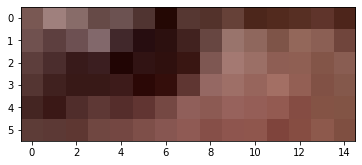

In [20]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

입력을 위해 이미지를 120x80 으로 resize 한 후, 배치(batch)를 나타낼 수 있는 4차원 텐서로 변경한다. 우선 이미지 1장에 대해서 출력을 하려 하니 지금은 배치 크기(batch size)를 1로 만들면 되겠다.

In [21]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.59295309e-03 1.27376057e-03]
  [1.19998184e+02 7.99960327e+01]
  [5.28573914e+01 2.71381721e+01]]]


출력결과를 뽑아보면 아래와 같이 나온다. 1행부터 좌측, 우측, 중앙 좌표를 나타낸다.

결과를 이미지에 출력해보자. **`pt`** 값은 *120x80* 으로 뽑았는데 우리가 사용하는 데이터 크기는 *60x40*이다. 따라서 **`pt`** 에 **`0.5`** 를 곱해서 그림에 출력한다.

> _(주의) **`pt`**값을 뽑을때의 이미지 크기 기준(120X80)은 고정이지만, 사용하는 데이터의 크기는 매번 달라질 것이다. 보정치 설정에 유의하자._

[0. 0.]
[120.  80.]
[53. 27.]


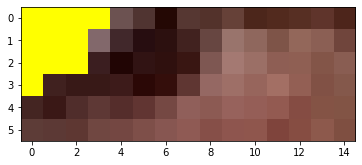

In [22]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

<img src="./image/result2.png" />

눈의 왼쪽은 정말 잘 찾은 것 같다. 반면 눈 중심과 오른쪽 위치는 5픽셀 정도의 오차를 보이는 것 같다. 더 정확한 성능(적은 에러)를 원한다면 데이터를 추가로 넣어야 할 것 같다.